# Stock Forecasting - LSTM vs ARIMA 
## 1. Preparation
#### In this section we are loading the necessary library, dataframe, shape(timeframe)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import random
import tensorflow as tf

# Seed for reproducibilty
SEED = 1001
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


# Load data and make sure indexing using date
df = pd.read_csv("walmart_stock_data.csv", skiprows=2, header=None)
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume", "MA10", "RSI", "MACD", "Signal"]
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)
df = df.asfreq("B").fillna(method="ffill")

# Cutoff dates for short and long term timeframe
last_date = df.index[-1]
cutoff_short = last_date - pd.Timedelta(days=7)
cutoff_long = last_date - pd.Timedelta(days=90)

# Data splitting for training and testing
train_short = df[:cutoff_short]['Close'].values.reshape(-1, 1)
train_long = df[:cutoff_long]['Close'].values.reshape(-1, 1)
test_short = df[cutoff_short:]['Close'].values[:7]
test_long = df[cutoff_long:]['Close'].values[:90]

C:\Users\chris\AppData\Local\Temp\ipykernel_39488\4277341229.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
C:\Users\chris\AppData\Local\Temp\ipykernel_39488\4277341229.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq("B").fillna(method="ffill")


## 2. Sequencing and LSTM Model
#### In this section we are appending the data as it is a time-series data and we are defining the model LSTM with the standard parameters. And then we forecast using the model 

In [7]:
# Preparing data sequencing before being processed by LSTM
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# LSTM model and training + scaler
def lstm_forecast(train_data, horizon):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(train_data)
    X, y = create_sequences(scaled, 20)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(20, 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, batch_size=32, verbose=0)

    last_seq = scaled[-20:]
    preds = []
    temp_seq = last_seq.copy()
    for _ in range(horizon):
        pred_scaled = model.predict(temp_seq.reshape(1, 20, 1), verbose=0)[0][0]
        preds.append(pred_scaled)
        temp_seq = np.append(temp_seq[1:], [[pred_scaled]], axis=0)
    return scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

In [8]:
# Forecasting LSTM
short_lstm = lstm_forecast(train_short, 7)
long_lstm = lstm_forecast(train_long, 90)
short_arima = ARIMA(train_short.flatten(), order=(5, 1, 0)).fit().forecast(7)
long_arima = ARIMA(train_long.flatten(), order=(5, 1, 0)).fit().forecast(90)


c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 3. Evaluation
#### In this section we compare LSTM vs ARIMA's result according to the agreed metrics

In [ ]:
# Evaluation
def evaluate(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    return rmse, mape

# Aligning lengths of datas
min_len_short = min(len(test_short), len(short_lstm), len(short_arima))
min_len_long = min(len(test_long), len(long_lstm), len(long_arima))

# Truncate everything to match
s_rmse_lstm, s_mape_lstm = evaluate(test_short[:min_len_short], short_lstm[:min_len_short])
l_rmse_lstm, l_mape_lstm = evaluate(test_long[:min_len_long], long_lstm[:min_len_long])
s_rmse_arima, s_mape_arima = evaluate(test_short[:min_len_short], short_arima[:min_len_short])
l_rmse_arima, l_mape_arima = evaluate(test_long[:min_len_long], long_arima[:min_len_long])

# Print Results
print(f"LSTM  - Short RMSE: {s_rmse_lstm:.2f}, MAPE: {s_mape_lstm:.2f}%")
print(f"ARIMA - Short RMSE: {s_rmse_arima:.2f}, MAPE: {s_mape_arima:.2f}%")
print(f"LSTM  - Long RMSE: {l_rmse_lstm:.2f}, MAPE: {l_mape_lstm:.2f}%")
print(f"ARIMA - Long RMSE: {l_rmse_arima:.2f}, MAPE: {l_mape_arima:.2f}%")



LSTM  - Short RMSE: 2.60, MAPE: 2.59%
ARIMA - Short RMSE: 1.67, MAPE: 1.48%
LSTM  - Long RMSE: 6.19, MAPE: 5.04%
ARIMA - Long RMSE: 7.86, MAPE: 6.56%


## 4. Plots
#### In this section we have to reshape the data length to make sure the plot represents the model's output and analysis

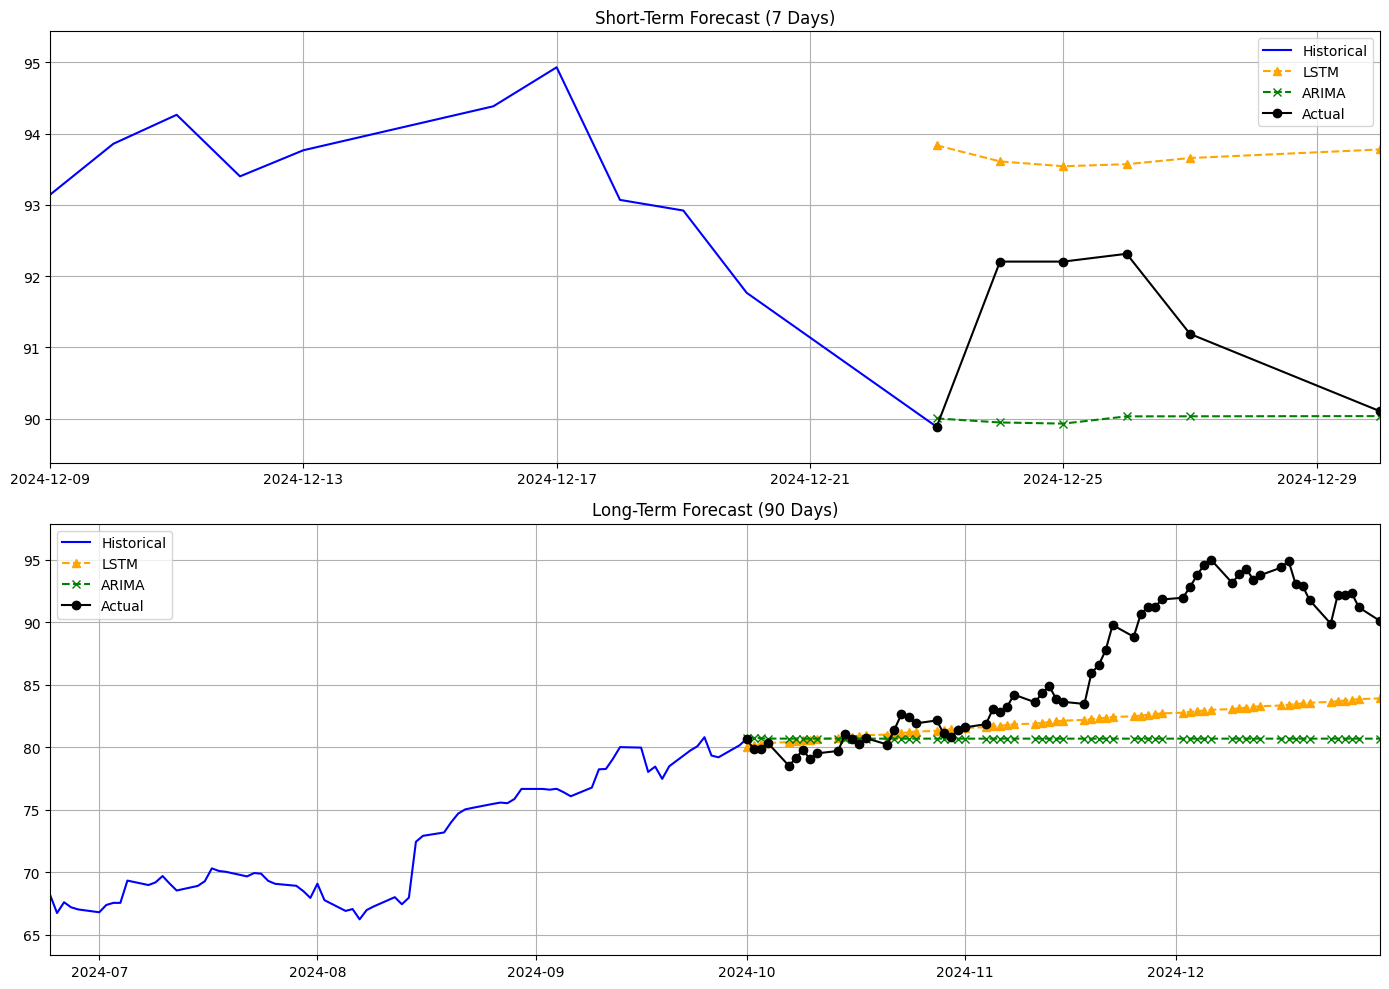

In [10]:
# Recalculate variables for plotting (due to uneven lengths)
min_len_short = min(len(test_short), len(short_lstm), len(short_arima))
short_lstm = short_lstm[:min_len_short]
short_arima = short_arima[:min_len_short]
test_short = test_short[:min_len_short]
dates_short = df[cutoff_short:].index[:min_len_short]
historical_short = df[cutoff_short - pd.Timedelta(days=14):cutoff_short]


prev_day = cutoff_short - pd.Timedelta(days=1)
last_close = df.loc[:prev_day, 'Close'].iloc[-1]
short_lstm_plot = short_lstm
dates_short_plot = dates_short
min_len_long = min(len(test_long), len(long_lstm), len(long_arima))
long_lstm = long_lstm[:min_len_long]
long_arima = long_arima[:min_len_long]
test_long = test_long[:min_len_long]
dates_long = df[cutoff_long:].index[:min_len_long]
historical_long = df[cutoff_long - pd.Timedelta(days=100):cutoff_long]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# SHORT TERM 
short_all = np.concatenate([
    historical_short['Close'].values,
    test_short,
    short_lstm,
    short_arima
])
ymin_short, ymax_short = short_all.min(), short_all.max()
ybuffer_short = (ymax_short - ymin_short) * 0.1

ax1.plot(historical_short.index, historical_short['Close'], label="Historical", color="blue")
ax1.plot(dates_short_plot, short_lstm_plot, label="LSTM", color="orange", linestyle="--", marker="^")
ax1.plot(dates_short, short_arima, label="ARIMA", color="green", linestyle="--", marker="x")
ax1.plot(dates_short, test_short, label="Actual", color="black", marker="o")
ax1.set_title("Short-Term Forecast (7 Days)")
ax1.set_ylim(ymin_short - ybuffer_short, ymax_short + ybuffer_short)
ax1.set_xlim(historical_short.index.min(), dates_short[-1])
ax1.grid(True)
ax1.legend()

# LONG TERM
long_all = np.concatenate([
    historical_long['Close'].values,
    test_long,
    long_lstm,
    long_arima
])
ymin_long, ymax_long = long_all.min(), long_all.max()
ybuffer_long = (ymax_long - ymin_long) * 0.1

ax2.plot(historical_long.index, historical_long['Close'], label="Historical", color="blue")
ax2.plot(dates_long, long_lstm, label="LSTM", color="orange", linestyle="--", marker="^")
ax2.plot(dates_long, long_arima, label="ARIMA", color="green", linestyle="--", marker="x")
ax2.plot(dates_long, test_long, label="Actual", color="black", marker="o")
ax2.set_title("Long-Term Forecast (90 Days)")
ax2.set_ylim(ymin_long - ybuffer_long, ymax_long + ybuffer_long)
ax2.set_xlim(historical_long.index.min(), dates_long[-1])
ax2.grid(True)
ax2.legend()

# FINAL LAYOUT
plt.tight_layout()
plt.show()


## 4. Calculating LSTM vs ARIMA without RSI, MA10 and MACD
#### In this section we will test the model using just basic features from the dataset provided and see whether adding RSI, MA10 and MACD actually helps with the accuracy

In [ ]:
# Forecasting LSTM and ARIMA without RSI, MA10, MACD
df_no_indicators = df.drop(columns=[col for col in ['RSI', 'MA10', 'MACD'] if col in df.columns])
price_data = df_no_indicators.iloc[:, 0].values.reshape(-1, 1)

# Define train/test splits
cutoff_short = len(price_data) - 7
cutoff_long = len(price_data) - 90
train_short_ni = price_data[:cutoff_short]
test_short_ni = price_data[cutoff_short:]
train_long_ni = price_data[:cutoff_long]
test_long_ni = price_data[cutoff_long:]

# LSTM and ARIMA forecasts
short_lstm_ni = lstm_forecast(train_short_ni, 7)
long_lstm_ni = lstm_forecast(train_long_ni, 90)
short_arima_ni = ARIMA(train_short_ni.flatten(), order=(5, 1, 0)).fit().forecast(7)
long_arima_ni = ARIMA(train_long_ni.flatten(), order=(5, 1, 0)).fit().forecast(90)

# Evaluate 
min_len_short_ni = min(len(test_short_ni), len(short_lstm_ni), len(short_arima_ni))
min_len_long_ni = min(len(test_long_ni), len(long_lstm_ni), len(long_arima_ni))

s_rmse_lstm_ni, s_mape_lstm_ni = evaluate(test_short_ni[:min_len_short_ni], short_lstm_ni[:min_len_short_ni])
l_rmse_lstm_ni, l_mape_lstm_ni = evaluate(test_long_ni[:min_len_long_ni], long_lstm_ni[:min_len_long_ni])
s_rmse_arima_ni, s_mape_arima_ni = evaluate(test_short_ni[:min_len_short_ni], short_arima_ni[:min_len_short_ni])
l_rmse_arima_ni, l_mape_arima_ni = evaluate(test_long_ni[:min_len_long_ni], long_arima_ni[:min_len_long_ni])

# Print results
print("Without RSI, MA10, MACD:")
print(f"LSTM  - Short RMSE: {s_rmse_lstm_ni:.2f}, MAPE: {s_mape_lstm_ni:.2f}%")
print(f"ARIMA - Short RMSE: {s_rmse_arima_ni:.2f}, MAPE: {s_mape_arima_ni:.2f}%")
print(f"LSTM  - Long RMSE: {l_rmse_lstm_ni:.2f}, MAPE: {l_mape_lstm_ni:.2f}%")
print(f"ARIMA - Long RMSE: {l_rmse_arima_ni:.2f}, MAPE: {l_mape_arima_ni:.2f}%")


c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Without RSI, MA10, MACD:
LSTM  - Short RMSE: 3.84, MAPE: 4.06%
ARIMA - Short RMSE: 1.76, MAPE: 1.65%
LSTM  - Long RMSE: 37.10, MAPE: 38.69%
ARIMA - Long RMSE: 10.49, MAPE: 9.76%


## 5. Conclusion
#### a. We can see that ARIMA outperforms LSTM in the short term forecasting, while LSTM performs better at long term forecasting than ARIMA, just as the paper hypothesized.

#### b. The adding of relevant parameters such as RSI, MA10, MACD improves both ARIMA and LSTM's performance in predicting both short and long term forecasting.